# Deep Learning-Powered Sequential Recommendation System

Hello there! I'm thrilled to embark on this project to build a sequential recommendation system. My goal today, Sunday, May 18, 2025, is to create a model that can predict the next item a user might be interested in, based on the sequence of items they've interacted with previously. This is super relevant for platforms like TikTok, Netflix, or Spotify, where understanding user journey and evolving preferences is key!

**What is Sequential Recommendation?**

Traditional recommendation systems often look at a user's overall preferences (e.g., all movies rated highly). Sequential recommenders, on the other hand, pay close attention to the *order* and *recency* of interactions. For example, if I just watched two sci-fi movies back-to-back, a sequential recommender is more likely to suggest another sci-fi movie right now, even if my long-term preference includes other genres.

**Our Tech Stack for this Adventure:**
* **Python 3:** Our trusty programming language.
* **PyTorch:** The deep learning framework we'll use to build our neural network.
* **Pandas:** For loading, manipulating, and exploring our dataset.
* **NumPy:** For efficient numerical operations.
* **Scikit-learn:** For some utility functions, though we'll implement core logic ourselves.
* **Matplotlib:** For visualizing our training progress.

Let's get started!

## Phase 1: Data Acquisition & Initial Exploration

Every good machine learning project starts with good data! 

**1. Choosing Our Dataset: MovieLens 1M**

For this project, I've decided to use the **MovieLens 1M dataset**. It's a classic dataset in the recommendation systems field, containing 1 million ratings from about 6,000 users on approximately 4,000 movies. It includes timestamps, which are crucial for sequential modeling.

**2. Downloading the Dataset:**

You can download it from the GroupLens website: [MovieLens 1M Dataset](https://grouplens.org/datasets/movielens/ml-1m/). You'll get a `ml-1m.zip` file. Go ahead and extract it into a known location in your project directory (e.g., a `data/` folder).

**3. Understanding `ratings.dat`:**

The key file we're interested in is `ratings.dat`. According to its README, it has the following format:
`UserID::MovieID::Rating::Timestamp`
* `UserID`: Integer ID for the user.
* `MovieID`: Integer ID for the movie.
* `Rating`: An integer from 1 to 5 stars.
* `Timestamp`: Unix timestamp (seconds since January 1, 1970).

Let's load this data using Pandas and take a first look.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt # For plotting later

# --- IMPORTANT: SET YOUR DATA PATH HERE ---
# Replace this with the actual path to your extracted 'ml-1m' folder
# Using a raw string for Windows path compatibility
DATA_DIR = r'C:\Users\amanp\OneDrive - purdue.edu\Spring 2025\Projects\sequential recommender system\ml-1m' 
# Example for macOS/Linux: DATA_DIR = './data/ml-1m/'
RATINGS_FILE_PATH = os.path.join(DATA_DIR, 'ratings.dat')
# -------

# Define column names as per the README of MovieLens 1M
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

# Check if the file exists before attempting to load
if not os.path.exists(RATINGS_FILE_PATH):
    print(f"Error: ratings.dat not found at {RATINGS_FILE_PATH}")
    print("Please download the MovieLens 1M dataset, extract it, and update the DATA_DIR variable.")
    df_ratings = None 
else:
    print(f"Loading data from: {RATINGS_FILE_PATH}")
    df_ratings = pd.read_csv(
        RATINGS_FILE_PATH,
        sep='::',
        header=None,
        names=column_names,
        engine='python',
        encoding='latin-1'
    )

    print("\nFirst 5 rows of the dataset:")
    print(df_ratings.head())

    print("\nDataset Information:")
    df_ratings.info()

    print("\nBasic Statistics:")
    print(df_ratings.describe())

    print("\nNumber of unique users and items:")
    print(f"Unique users: {df_ratings['user_id'].nunique()}")
    print(f"Unique items (movies): {df_ratings['item_id'].nunique()}")
    print(f"Total ratings: {len(df_ratings)}")

Loading data from: C:\Users\amanp\OneDrive - purdue.edu\Spring 2025\Projects\sequential recommender system\ml-1m\ratings.dat

First 5 rows of the dataset:
   user_id  item_id  rating  timestamp
0        1     1193       5  978300760
1        1      661       3  978302109
2        1      914       3  978301968
3        1     3408       4  978300275
4        1     2355       5  978824291

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   item_id    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB

Basic Statistics:
            user_id       item_id        rating     timestamp
count  1.000209e+06  1.000209e+06  1.000209e+06  1.000209e+06
mean   3.024512e+03  1.865540e+03  3.581564e+00  9.7224

## Phase 2: Data Preprocessing

This is arguably the most crucial part for building effective sequential models. Our raw data needs to be transformed into a format that our PyTorch model can understand and learn from. I'll break this down into several steps:

1.  **Filtering (Optional but Recommended):** We might want to remove users or items with very few interactions. This can help reduce noise and the size of our vocabulary, making training more manageable and potentially leading to better generalization for items/users with richer histories.
2.  **Temporal Ordering:** Ensure all interactions for each user are sorted by their timestamp. This is fundamental for sequential modeling.
3.  **ID Mapping (Vocabulary Creation):** Our model will work with numerical indices. We need to map the original `item_id`s to new, contiguous integer indices. We'll reserve index `0` specifically for padding.
4.  **Robust Splitting (Train/Validation/Test per User):** This is critical. We'll split each user's sequence: the last item for test, second-to-last for validation, and the rest for training.
5.  **Generating Input-Target Pairs & Padding:** From the training part of each user's sequence, we'll create multiple `(input_subsequence, target_item)` pairs. All input subsequences will be padded/truncated to a fixed `MAX_SEQUENCE_LENGTH`.

In [2]:
if df_ratings is None:
    print("Error: df_ratings was not loaded in Phase 1. Cannot proceed with preprocessing.")
else:
    print(f"Original shape: {df_ratings.shape}")
    df_ratings_processed = df_ratings.copy()

    min_user_interactions = 5
    min_item_interactions = 5

    print("\nFiltering users and items based on minimum interaction counts...")
    for _iter_count in range(5):
        initial_rows = len(df_ratings_processed)
        item_counts = df_ratings_processed['item_id'].value_counts()
        df_ratings_processed = df_ratings_processed[df_ratings_processed['item_id'].isin(item_counts[item_counts >= min_item_interactions].index)]
        user_counts = df_ratings_processed['user_id'].value_counts()
        df_ratings_processed = df_ratings_processed[df_ratings_processed['user_id'].isin(user_counts[user_counts >= min_user_interactions].index)]
        if len(df_ratings_processed) == initial_rows:
            print(f"Filtering converged after {_iter_count + 1} iteration(s).")
            break
    else:
        print("Filtering reached max iterations.")

    print(f"Shape after filtering: {df_ratings_processed.shape}")
    print(f"Unique users after filtering: {df_ratings_processed['user_id'].nunique()}")
    print(f"Unique items after filtering: {df_ratings_processed['item_id'].nunique()}")

    print("\nSorting interactions by user_id and timestamp...")
    df_sorted = df_ratings_processed.sort_values(['user_id', 'timestamp'])

    user_item_sequences_raw = df_sorted.groupby('user_id')['item_id'].apply(list)
    print("\nExample of raw item sequences for a few users (after filtering and sorting):")
    print(user_item_sequences_raw.head())

    print("\nCreating item vocabulary and mapping IDs...")
    all_item_ids_in_sequences = set()
    for user_seq in user_item_sequences_raw:
        for item_id in user_seq:
            all_item_ids_in_sequences.add(item_id)

    sorted_unique_item_ids = sorted(list(all_item_ids_in_sequences))
    item_to_idx = {item_id: index + 1 for index, item_id in enumerate(sorted_unique_item_ids)}
    idx_to_item = {index + 1: item_id for index, item_id in enumerate(sorted_unique_item_ids)}
    padding_token_idx = 0 
    num_unique_items_vocab = len(item_to_idx) + 1

    print(f"Total unique items in vocabulary (item_to_idx): {len(item_to_idx)}")
    print(f"Vocabulary size for embedding layer (including padding token 0): {num_unique_items_vocab}")
    if item_to_idx:
        print(f"Example item_to_idx entry: {list(item_to_idx.items())[0]}")
        print(f"Example idx_to_item entry: {list(idx_to_item.items())[0]}")

    user_item_sequences_indexed = user_item_sequences_raw.apply(
        lambda seq: [item_to_idx[item] for item in seq if item in item_to_idx]
    )
    user_item_sequences_indexed = user_item_sequences_indexed[user_item_sequences_indexed.apply(len) > 0]

    print("\nExample of indexed item sequences for a few users:")
    print(user_item_sequences_indexed.head())

    MAX_SEQUENCE_LENGTH = 20
    print(f"\nUsing MAX_SEQUENCE_LENGTH = {MAX_SEQUENCE_LENGTH} for input sequences.")

    train_input_sequences, train_target_items = [], []
    val_input_sequences, val_target_items = [], []
    test_input_sequences, test_target_items = [], []

    if user_item_sequences_indexed.empty:
        print("Error: 'user_item_sequences_indexed' is empty. Cannot proceed with splitting.")
    else:
        print("\nSplitting data per user and generating input-target pairs with padding...")
        for user_id, full_indexed_seq in user_item_sequences_indexed.items():
            if len(full_indexed_seq) < 3:
                continue
            test_target = full_indexed_seq[-1]
            test_history = full_indexed_seq[:-1]
            test_input_padded = [padding_token_idx] * (MAX_SEQUENCE_LENGTH - len(test_history[-MAX_SEQUENCE_LENGTH:])) + test_history[-MAX_SEQUENCE_LENGTH:]
            test_input_sequences.append(test_input_padded)
            test_target_items.append(test_target)

            val_target = full_indexed_seq[-2]
            val_history = full_indexed_seq[:-2]
            if val_history:
                val_input_padded = [padding_token_idx] * (MAX_SEQUENCE_LENGTH - len(val_history[-MAX_SEQUENCE_LENGTH:])) + val_history[-MAX_SEQUENCE_LENGTH:]
                val_input_sequences.append(val_input_padded)
                val_target_items.append(val_target)

            train_sequence_part = full_indexed_seq[:-2]
            if len(train_sequence_part) >= 2:
                for i in range(1, len(train_sequence_part)):
                    history_for_train = train_sequence_part[:i]
                    target_for_train = train_sequence_part[i]
                    current_input_for_train = history_for_train[-MAX_SEQUENCE_LENGTH:]
                    padding_needed = MAX_SEQUENCE_LENGTH - len(current_input_for_train)
                    padded_input_for_train = [padding_token_idx] * padding_needed + current_input_for_train
                    train_input_sequences.append(padded_input_for_train)
                    train_target_items.append(target_for_train)

        X_train = np.array(train_input_sequences)
        y_train = np.array(train_target_items)
        X_val = np.array(val_input_sequences)
        y_val = np.array(val_target_items)
        X_test = np.array(test_input_sequences)
        y_test = np.array(test_target_items)

        print(f"\nTraining samples: {len(X_train)}")
        if len(X_train) > 0: print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        print(f"Validation samples: {len(X_val)}")
        if len(X_val) > 0: print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
        print(f"Test samples: {len(X_test)}")
        if len(X_test) > 0: print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

        if len(X_train) > 0:
            print("\nExample training input sequence (padded):", X_train[0])
            print("Corresponding training target item index:", y_train[0])

Original shape: (1000209, 4)

Filtering users and items based on minimum interaction counts...
Filtering converged after 2 iteration(s).
Shape after filtering: (999611, 4)
Unique users after filtering: 6040
Unique items after filtering: 3416

Sorting interactions by user_id and timestamp...

Example of raw item sequences for a few users (after filtering and sorting):
user_id
1    [3186, 1270, 1721, 1022, 2340, 1836, 3408, 280...
2    [1198, 1210, 1217, 2717, 1293, 2943, 1225, 119...
3    [593, 2858, 3534, 1968, 1431, 1961, 1266, 1378...
4    [1210, 1097, 3468, 480, 3527, 260, 1196, 1198,...
5    [2717, 908, 919, 1250, 356, 2858, 1127, 2188, ...
Name: item_id, dtype: object

Creating item vocabulary and mapping IDs...
Total unique items in vocabulary (item_to_idx): 3416
Vocabulary size for embedding layer (including padding token 0): 3417
Example item_to_idx entry: (1, 1)
Example idx_to_item entry: (1, 1)

Example of indexed item sequences for a few users:
user_id
1    [2758, 1069, 1445

#### Creating PyTorch Datasets and DataLoaders

Now, I'll wrap our NumPy arrays into PyTorch `Dataset` objects and then use `DataLoader` to efficiently create batches for training, validation, and testing.

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class SequentialMovieDataset(Dataset):
    """Custom Dataset for our sequential movie recommendation task."""
    def __init__(self, sequences_np, targets_np):
        if not isinstance(sequences_np, np.ndarray) or not isinstance(targets_np, np.ndarray):
            raise TypeError("Inputs 'sequences_np' and 'targets_np' must be NumPy arrays.")
        if len(sequences_np) != len(targets_np):
            raise ValueError("Sequences and targets must have the same number of samples.")
        self.sequences = torch.tensor(sequences_np, dtype=torch.long)
        self.targets = torch.tensor(targets_np, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

BATCH_SIZE = 128 
train_loader, val_loader, test_loader = None, None, None

if 'X_train' in locals() and len(X_train) > 0 and len(y_train) > 0:
    train_dataset = SequentialMovieDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) 
    print(f"\nCreated train_loader with {len(train_loader)} batches of approx size {BATCH_SIZE}.")
else:
    print("\nWarning: Training data is empty or not defined. Train DataLoader not created.")

if 'X_val' in locals() and len(X_val) > 0 and len(y_val) > 0:
    val_dataset = SequentialMovieDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    print(f"Created val_loader with {len(val_loader)} batches of approx size {BATCH_SIZE}.")
else:
    print("\nWarning: Validation data is empty or not defined. Validation DataLoader not created.")

if 'X_test' in locals() and len(X_test) > 0 and len(y_test) > 0:
    test_dataset = SequentialMovieDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    print(f"Created test_loader with {len(test_loader)} batches of approx size {BATCH_SIZE}.")
else:
    print("\nWarning: Test data is empty or not defined. Test DataLoader not created.")


Created train_loader with 7668 batches of approx size 128.
Created val_loader with 48 batches of approx size 128.
Created test_loader with 48 batches of approx size 128.


## Phase 3: Model Building (PyTorch - GRU Focus First)

Now for the exciting part – building our deep learning model! I'll start with a GRU (Gated Recurrent Unit) based model. GRUs are a type of Recurrent Neural Network (RNN) that are quite effective at capturing dependencies in sequential data like ours.

**Our GRU Model Architecture will consist of:**

1.  **Embedding Layer (`nn.Embedding`):** Learns a dense vector representation for each movie. `padding_idx=0` is crucial.
2.  **GRU Layer (`nn.GRU`):** Processes the sequence of item embeddings, maintaining a hidden state.
3.  **Dropout Layer (`nn.Dropout`):** For regularization to prevent overfitting.
4.  **Linear Layer (`nn.Linear`):** Takes the GRU's final relevant output and projects it to scores for all items in our vocabulary.

**Note on RNN Output for Prediction:**
When using RNNs (like GRU or LSTM) with padded sequences, correctly selecting the output for prediction is important. The `final_hidden_state` (from the last layer) is often used as it summarizes the entire sequence processed. If using `pack_padded_sequence` (a more advanced PyTorch utility for variable-length sequences), you'd unpack and select the output at the actual sequence lengths. Our current simpler approach relies on the `padding_idx` in the embedding layer ensuring that padded steps contribute minimally (ideally zero) to the GRU's computation, making the `final_hidden_state` a reasonable representation of the *seen* sequence.

In [18]:
import torch.nn as nn

class GRURecommender(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 num_layers=1, dropout_p=0.3, padding_idx=0):
        super(GRURecommender, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=padding_idx)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_dim, num_layers=self.num_layers, 
                          batch_first=True, dropout=dropout_p if self.num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, input_sequences, hidden_state=None):
        # input_sequences shape: (batch_size, MAX_SEQUENCE_LENGTH)
        embedded_seq = self.embedding(input_sequences) # (batch_size, MAX_SEQUENCE_LENGTH, embedding_dim)
        embedded_seq = self.dropout(embedded_seq) 
        
        # gru_output contains output of GRU at each time step: (batch_size, MAX_SEQUENCE_LENGTH, hidden_dim)
        # final_hidden_state is the hidden state of the last time step: (num_layers, batch_size, hidden_dim)
        gru_output, final_hidden_state = self.gru(embedded_seq, hidden_state)
        
        # We use the final hidden state of the last GRU layer as it summarizes the sequence.
        if self.num_layers > 1:
            relevant_hidden_state = final_hidden_state[-1] # (batch_size, hidden_dim)
        else:
            relevant_hidden_state = final_hidden_state.squeeze(0) # (batch_size, hidden_dim)

        out_dp = self.dropout(relevant_hidden_state)
        logits = self.fc(out_dp) # (batch_size, vocab_size)
        return logits

# Model Hyperparameters (can be tuned later)
EMBEDDING_DIM = 64   
HIDDEN_DIM = 128     
NUM_GRU_LAYERS = 1   
DROPOUT_PROB = 0.3   

if 'num_unique_items_vocab' not in locals() or num_unique_items_vocab is None:
    print("Error: 'num_unique_items_vocab' is not defined. Please run the preprocessing cells.")
    model = None # Ensure model is None if vocab size is missing
else:
    print("\nInstantiating the GRURecommender model...")
    model = GRURecommender(
        vocab_size=num_unique_items_vocab,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=num_unique_items_vocab,
        num_layers=NUM_GRU_LAYERS,
        dropout_p=DROPOUT_PROB,
        padding_idx=padding_token_idx 
    )
    print("\nModel Architecture:")
    print(model)

    if train_loader is not None and len(train_loader) > 0:
        print("\nPerforming a sanity check with a dummy batch from train_loader...")
        try:
            dummy_batch_sequences, _ = next(iter(train_loader))
            with torch.no_grad():
                model.eval() 
                dummy_output_logits = model(dummy_batch_sequences)
                model.train() 
            print(f"Dummy batch input sequences shape: {dummy_batch_sequences.shape}")
            print(f"Dummy batch output logits shape: {dummy_output_logits.shape}")
            assert dummy_output_logits.shape[0] == dummy_batch_sequences.shape[0]
            assert dummy_output_logits.shape[1] == num_unique_items_vocab
            print("Sanity check passed: Output dimensions are as expected.")
        except Exception as e:
            print(f"Error during sanity check: {e}")
    else:
        print("\nSkipping dummy batch sanity check as train_loader is not available or is empty.")


Instantiating the GRURecommender model...

Model Architecture:
GRURecommender(
  (embedding): Embedding(3417, 64, padding_idx=0)
  (gru): GRU(64, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=3417, bias=True)
)

Performing a sanity check with a dummy batch from train_loader...
Dummy batch input sequences shape: torch.Size([128, 20])
Dummy batch output logits shape: torch.Size([128, 3417])
Sanity check passed: Output dimensions are as expected.


## Phase 4: Training our PyTorch Model

With our data prepared and model defined, it's time to train it! This involves:

1.  **Setting up the Device:** Use GPU if available.
2.  **Defining the Loss Function:** `nn.CrossEntropyLoss` for multi-class classification.
3.  **Choosing an Optimizer:** `torch.optim.Adam` is a good default.
4.  **The Training & Validation Loop:** Iterate through epochs, and within each epoch, iterate through batches. Perform forward pass, calculate loss, backward pass, and update weights. Evaluate on the validation set after each epoch.


Using device: cuda

Starting Training for GRU model for 10 epochs...
Optimizer: Adam, Learning Rate: 0.001
Loss Function: CrossEntropyLoss
  Epoch 1, Batch 2000/7668, Current Avg Batch Loss: 6.6527
  Epoch 1, Batch 4000/7668, Current Avg Batch Loss: 6.1775
  Epoch 1, Batch 6000/7668, Current Avg Batch Loss: 5.9276
Epoch [1/10] - Training Loss: 6.4668
Epoch [1/10] - Validation Loss: 6.2175, Validation Accuracy: 0.0348
  Epoch 2, Batch 2000/7668, Current Avg Batch Loss: 6.1773
  Epoch 2, Batch 4000/7668, Current Avg Batch Loss: 5.8409
  Epoch 2, Batch 6000/7668, Current Avg Batch Loss: 5.9170
Epoch [2/10] - Training Loss: 5.9469
Epoch [2/10] - Validation Loss: 6.0136, Validation Accuracy: 0.0399
  Epoch 3, Batch 2000/7668, Current Avg Batch Loss: 5.7926
  Epoch 3, Batch 4000/7668, Current Avg Batch Loss: 5.7060
  Epoch 3, Batch 6000/7668, Current Avg Batch Loss: 6.0381
Epoch [3/10] - Training Loss: 5.8197
Epoch [3/10] - Validation Loss: 5.9284, Validation Accuracy: 0.0424
  Epoch 4, Bat

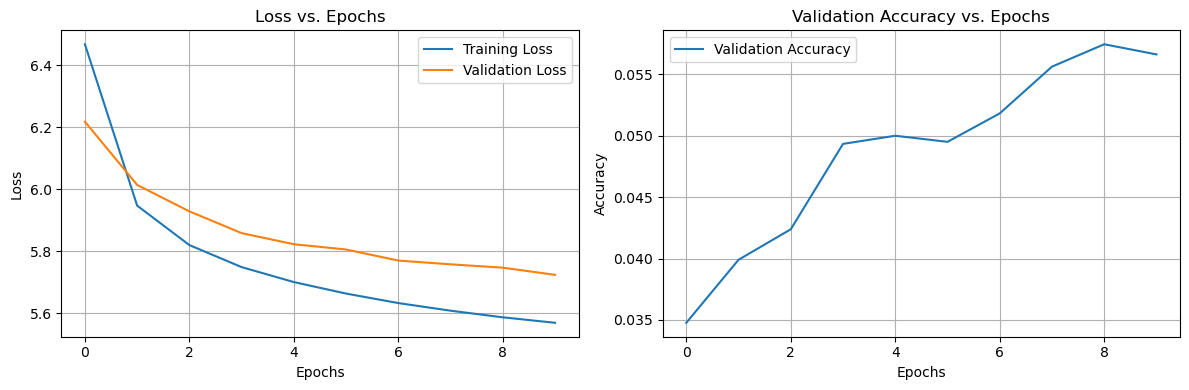

In [7]:
if model is None or 'num_unique_items_vocab' not in locals() or num_unique_items_vocab is None:
    print("Error: Model or essential variables not defined. Cannot proceed with training.")
elif train_loader is None or (val_loader is None and 'X_val' in locals() and len(X_val) > 0) :
    print("Error: train_loader or val_loader is not available. Cannot proceed with training.")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nUsing device: {device}")
    model.to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=padding_token_idx) 
    LEARNING_RATE = 0.001 
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    NUM_EPOCHS = 10 

    print(f"\nStarting Training for GRU model for {NUM_EPOCHS} epochs...")
    print(f"Optimizer: Adam, Learning Rate: {LEARNING_RATE}")
    print(f"Loss Function: CrossEntropyLoss")

    # Lists to store training history for plotting
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_train_loss = 0.0
        num_train_samples = 0
        
        if len(train_loader) == 0:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Training loader is empty. Skipping.")
            train_loss_history.append(float('nan')) # Or some indicator for no training
            if val_loader is not None and len(val_loader) > 0:
                val_loss_history.append(float('nan'))
                val_accuracy_history.append(float('nan'))
            continue
            
        for batch_idx, (batch_sequences, batch_targets) in enumerate(train_loader):
            batch_sequences = batch_sequences.to(device)
            batch_targets = batch_targets.to(device)
            optimizer.zero_grad()
            outputs_logits = model(batch_sequences)
            loss = criterion(outputs_logits, batch_targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * batch_sequences.size(0)
            num_train_samples += batch_sequences.size(0)
            if (batch_idx + 1) % 2000 == 0: # Print progress less frequently for faster overall training
                print(f"  Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)}, Current Avg Batch Loss: {loss.item():.4f}")
        
        epoch_train_loss = running_train_loss / num_train_samples if num_train_samples > 0 else 0
        train_loss_history.append(epoch_train_loss)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Training Loss: {epoch_train_loss:.4f}")

        if val_loader is not None and len(val_loader) > 0:
            model.eval()
            running_val_loss = 0.0
            correct_val_predictions = 0
            num_val_samples = 0
            with torch.no_grad():
                for batch_sequences, batch_targets in val_loader:
                    batch_sequences = batch_sequences.to(device)
                    batch_targets = batch_targets.to(device)
                    outputs_logits = model(batch_sequences)
                    loss = criterion(outputs_logits, batch_targets)
                    running_val_loss += loss.item() * batch_sequences.size(0)
                    _, predicted_item_indices = torch.max(outputs_logits, 1)
                    correct_val_predictions += (predicted_item_indices == batch_targets).sum().item()
                    num_val_samples += batch_targets.size(0)
            epoch_val_loss = running_val_loss / num_val_samples if num_val_samples > 0 else 0
            val_accuracy = correct_val_predictions / num_val_samples if num_val_samples > 0 else 0
            val_loss_history.append(epoch_val_loss)
            val_accuracy_history.append(val_accuracy)
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        elif 'X_val' in locals() and len(X_val) == 0:
             print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Validation data is empty. Skipping validation.")
             val_loss_history.append(float('nan'))
             val_accuracy_history.append(float('nan'))
        else:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Validation loader not available or empty. Skipping validation.")
            val_loss_history.append(float('nan'))
            val_accuracy_history.append(float('nan'))
    print("\nGRU Model Training Finished.")

    # Plotting training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Training Loss')
    if any(not np.isnan(x) for x in val_loss_history):
      plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    if any(not np.isnan(x) for x in val_accuracy_history):
      plt.plot(val_accuracy_history, label='Validation Accuracy')
      plt.title('Validation Accuracy vs. Epochs')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.grid(True)
    
    plt.tight_layout()
    plt.show()

#### Saving the Trained GRU Model
It's good practice to save the model's state dictionary after training.

In [10]:
if 'model' in locals() and model is not None:
    MODEL_SAVE_PATH = 'gru_sequential_recommender_ml1m.pth'
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\nGRU Model state dictionary saved to: {MODEL_SAVE_PATH}")
else:
    print("\nGRU Model not defined or not trained. Skipping model saving.")


GRU Model state dictionary saved to: gru_sequential_recommender_ml1m.pth


## Phase 5: Evaluation (PyTorch)

Accuracy (predicting the exact next item) is often too strict. We'll use more standard recommendation metrics:
* **Hit Rate @ K (HR@K):** Proportion of times the true next item is in the top K recommendations.
* **Mean Reciprocal Rank @ K (MRR@K):** Considers the rank of the true item if in the top K.
* **Normalized Discounted Cumulative Gain @ K (NDCG@K):** Also considers the position, giving more weight to hits at earlier ranks.

I'll use the `evaluate_recommender_metrics_v2` function which includes NDCG, and evaluate our trained GRU model on the `test_loader`.

In [11]:
# Definition of calculate_ndcg_at_k and evaluate_recommender_metrics_v2
import numpy as np # Ensure numpy is imported for np.log2

def calculate_ndcg_at_k(true_item_tensor, predicted_top_k_items_tensor, k_val):
    actual_k = min(k_val, len(predicted_top_k_items_tensor))
    if actual_k == 0: return 0.0
    top_k_predictions = predicted_top_k_items_tensor[:actual_k]
    dcg = 0.0
    rank_tensor_tuple = (top_k_predictions == true_item_tensor).nonzero(as_tuple=True)
    if rank_tensor_tuple[0].numel() > 0:
        rank = rank_tensor_tuple[0].item() + 1 
        dcg = 1.0 / np.log2(rank + 1)
    idcg = 1.0 if dcg > 0 else 0.0
    return dcg / idcg if idcg > 0 else 0.0

def evaluate_recommender_metrics_v2(model_to_eval, data_loader, eval_device, k_values_list=[5, 10, 20]):
    if model_to_eval is None or data_loader is None or len(data_loader) == 0:
        print("Model or DataLoader not available/empty for evaluation_v2.")
        return {}, {}, {}
    model_to_eval.eval()
    total_samples = 0
    hits_at_k_counts = {k: 0 for k in k_values_list}
    mrr_sum_at_k_values = {k: 0.0 for k in k_values_list}
    ndcg_sum_at_k_values = {k: 0.0 for k in k_values_list}
    max_k = max(k_values_list)

    with torch.no_grad():
        for batch_sequences, batch_targets in data_loader:
            batch_sequences = batch_sequences.to(eval_device)
            batch_targets = batch_targets.to(eval_device)
            outputs_logits = model_to_eval(batch_sequences)
            _, top_k_indices_overall = torch.topk(outputs_logits, k=max_k, dim=1)
            for i in range(batch_targets.size(0)):
                true_item_idx_tensor = batch_targets[i]
                predicted_top_max_k_for_sample = top_k_indices_overall[i]
                for k_val in k_values_list:
                    current_top_k_preds = predicted_top_max_k_for_sample[:k_val]
                    is_hit = (true_item_idx_tensor == current_top_k_preds).any().item()
                    if is_hit:
                        hits_at_k_counts[k_val] += 1
                        rank_tensor_tuple = (current_top_k_preds == true_item_idx_tensor).nonzero(as_tuple=True)
                        if rank_tensor_tuple[0].numel() > 0:
                            rank = rank_tensor_tuple[0].item() + 1
                            mrr_sum_at_k_values[k_val] += (1.0 / rank)
                    ndcg_sum_at_k_values[k_val] += calculate_ndcg_at_k(true_item_idx_tensor, predicted_top_max_k_for_sample, k_val)
            total_samples += batch_targets.size(0)
    if total_samples == 0: return {}, {}, {}
    hr_results = {k: count / total_samples for k, count in hits_at_k_counts.items()}
    mrr_results = {k: summed_rr / total_samples for k, summed_rr in mrr_sum_at_k_values.items()}
    ndcg_results = {k: summed_ndcg / total_samples for k, summed_ndcg in ndcg_sum_at_k_values.items()}
    return hr_results, mrr_results, ndcg_results

# Perform evaluation on the test set using the trained GRU model ('model')
# These results will be stored globally for comparison later
test_hr_results, test_mrr_results, test_ndcg_results = {}, {}, {}
if 'model' in locals() and model is not None and test_loader is not None and len(test_loader) > 0:
    print("\nEvaluating GRU model performance on the Test Set (with NDCG)...")
    k_eval_values = [5, 10, 20]
    test_hr_results, test_mrr_results, test_ndcg_results = evaluate_recommender_metrics_v2(model, test_loader, device, k_values_list=k_eval_values)
    
    print("\nGRU Model - Test Set Evaluation Results:")
    for k_val in k_eval_values:
        print(f"  HR@{k_val}: {test_hr_results.get(k_val, 0):.4f}, MRR@{k_val}: {test_mrr_results.get(k_val, 0):.4f}, NDCG@{k_val}: {test_ndcg_results.get(k_val, 0):.4f}")
else:
    print("\nGRU Model or test_loader not available/empty. Skipping final evaluation on test set.")


Evaluating GRU model performance on the Test Set (with NDCG)...

GRU Model - Test Set Evaluation Results:
  HR@5: 0.1546, MRR@5: 0.0865, NDCG@5: 0.1033
  HR@10: 0.2308, MRR@10: 0.0966, NDCG@10: 0.1279
  HR@20: 0.3252, MRR@20: 0.1032, NDCG@20: 0.1518


## Phase 6: Further Steps & Iteration - Enhancing Our Recommender

Our initial GRU model provides a baseline. Now, let's explore improvements and alternative approaches.

### 6.1 More Training Epochs & Basic Hyperparameter Tweaks (with Early Stopping Example)

Training longer can help, but we risk overfitting. **Early stopping** is a technique where we monitor performance on a validation set and stop training if it doesn't improve for a certain number of epochs (patience). I'll demonstrate a simple version here.

**Key Idea for Early Stopping:**
1. Monitor validation loss after each epoch.
2. Keep track of the best validation loss seen so far and the model weights at that point.
3. If validation loss doesn't improve for `patience` consecutive epochs, stop training and revert to the best model weights found.


--- Phase 6.1: Extended GRU Training with Early Stopping Example ---

Starting Extended GRU Training for up to 30 epochs with Early Stopping (patience=5)...
Epoch [1/30] - Training Loss: 6.4571
Epoch [1/30] - Validation Loss: 6.1820, Validation Accuracy: 0.0353
  New best validation loss: 6.1820. Saving model state.
Epoch [2/30] - Training Loss: 5.9387
Epoch [2/30] - Validation Loss: 6.0210, Validation Accuracy: 0.0407
  New best validation loss: 6.0210. Saving model state.
Epoch [3/30] - Training Loss: 5.8178
Epoch [3/30] - Validation Loss: 5.9060, Validation Accuracy: 0.0469
  New best validation loss: 5.9060. Saving model state.
Epoch [4/30] - Training Loss: 5.7493
Epoch [4/30] - Validation Loss: 5.8706, Validation Accuracy: 0.0493
  New best validation loss: 5.8706. Saving model state.
Epoch [5/30] - Training Loss: 5.6996
Epoch [5/30] - Validation Loss: 5.8236, Validation Accuracy: 0.0442
  New best validation loss: 5.8236. Saving model state.
Epoch [6/30] - Training Loss: 5.6622


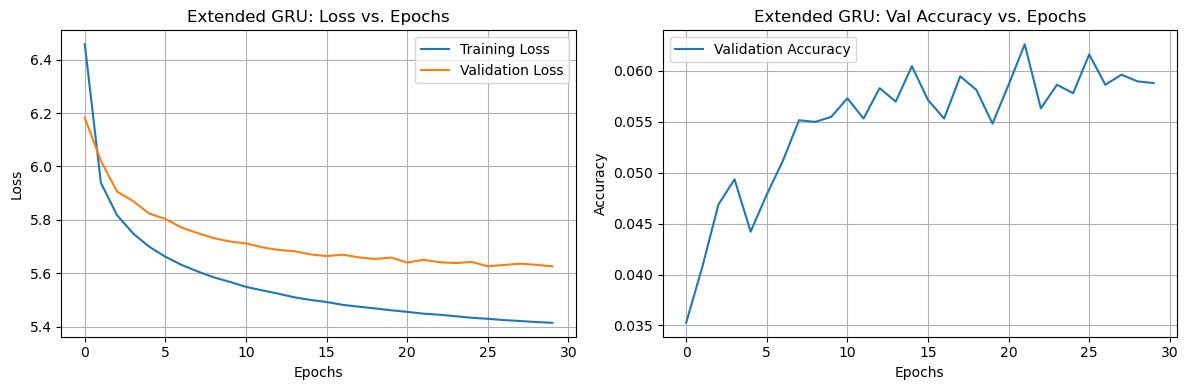


Evaluating Extended GRU model (best state) on Test Set...

Extended GRU Model - Test Set Results:
  HR@5: 0.1675, MRR@5: 0.0956, NDCG@5: 0.1134
  HR@10: 0.2460, MRR@10: 0.1059, NDCG@10: 0.1386
  HR@20: 0.3460, MRR@20: 0.1128, NDCG@20: 0.1638


In [12]:
print("\n--- Phase 6.1: Extended GRU Training with Early Stopping Example ---")
model_ext_gru = None # Initialize to handle cases where prerequisites are not met
model_ext_gru_test_results = None # Initialize

if 'num_unique_items_vocab' not in locals() or \
   'padding_token_idx' not in locals() or \
   'train_loader' not in locals() or \
   'val_loader' not in locals() or \
   'GRURecommender' not in locals() or \
   'EMBEDDING_DIM' not in locals() or \
   'HIDDEN_DIM' not in locals() or \
   'NUM_GRU_LAYERS' not in locals() or \
   'DROPOUT_PROB' not in locals() or \
   'device' not in locals() or \
   'evaluate_recommender_metrics_v2' not in locals() or \
   'test_loader' not in locals() or \
   'X_val' not in locals():
    print("Error: Necessary variables/classes for extended training not found. Ensure Phases 1-5 ran.")
else:
    # Hyperparameters for this extended run
    EXT_NUM_EPOCHS = 30       # Max epochs to train for
    EXT_LEARNING_RATE = 0.001 
    PATIENCE_EPOCHS = 5       # For early stopping

    model_ext_gru = GRURecommender(
        vocab_size=num_unique_items_vocab,
        embedding_dim=EMBEDDING_DIM, 
        hidden_dim=HIDDEN_DIM,     
        output_dim=num_unique_items_vocab,
        num_layers=NUM_GRU_LAYERS, 
        dropout_p=DROPOUT_PROB,    
        padding_idx=padding_token_idx
    ).to(device)

    criterion_ext = nn.CrossEntropyLoss(ignore_index=padding_token_idx)
    optimizer_ext = torch.optim.Adam(model_ext_gru.parameters(), lr=EXT_LEARNING_RATE)

    print(f"\nStarting Extended GRU Training for up to {EXT_NUM_EPOCHS} epochs with Early Stopping (patience={PATIENCE_EPOCHS})...")

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state_dict = None
    ext_train_loss_hist, ext_val_loss_hist, ext_val_acc_hist = [], [], []

    for epoch in range(EXT_NUM_EPOCHS):
        model_ext_gru.train()
        running_train_loss, num_train_samples = 0.0, 0
        if train_loader is None or len(train_loader) == 0: break
        for batch_sequences, batch_targets in train_loader:
            batch_sequences, batch_targets = batch_sequences.to(device), batch_targets.to(device)
            optimizer_ext.zero_grad()
            outputs_logits = model_ext_gru(batch_sequences)
            loss = criterion_ext(outputs_logits, batch_targets)
            loss.backward()
            optimizer_ext.step()
            running_train_loss += loss.item() * batch_sequences.size(0)
            num_train_samples += batch_sequences.size(0)
        
        epoch_train_loss = running_train_loss / num_train_samples if num_train_samples > 0 else 0
        ext_train_loss_hist.append(epoch_train_loss)
        print(f"Epoch [{epoch+1}/{EXT_NUM_EPOCHS}] - Training Loss: {epoch_train_loss:.4f}")

        if val_loader is not None and len(val_loader) > 0:
            model_ext_gru.eval()
            running_val_loss, correct_val_preds, num_val_samples = 0.0, 0, 0
            with torch.no_grad():
                for batch_sequences, batch_targets in val_loader:
                    batch_sequences, batch_targets = batch_sequences.to(device), batch_targets.to(device)
                    outputs_logits = model_ext_gru(batch_sequences)
                    loss = criterion_ext(outputs_logits, batch_targets)
                    running_val_loss += loss.item() * batch_sequences.size(0)
                    _, predicted_item_indices = torch.max(outputs_logits, 1)
                    correct_val_preds += (predicted_item_indices == batch_targets).sum().item()
                    num_val_samples += batch_targets.size(0)
            epoch_val_loss = running_val_loss / num_val_samples if num_val_samples > 0 else float('inf')
            val_accuracy = correct_val_preds / num_val_samples if num_val_samples > 0 else 0
            ext_val_loss_hist.append(epoch_val_loss)
            ext_val_acc_hist.append(val_accuracy)
            print(f"Epoch [{epoch+1}/{EXT_NUM_EPOCHS}] - Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                best_model_state_dict = model_ext_gru.state_dict().copy()
                epochs_no_improve = 0
                print(f"  New best validation loss: {best_val_loss:.4f}. Saving model state.")
            else:
                epochs_no_improve += 1
                print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s).")
            if epochs_no_improve >= PATIENCE_EPOCHS:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                if best_model_state_dict is not None:
                    model_ext_gru.load_state_dict(best_model_state_dict)
                    print("Loaded best model weights based on validation loss.")
                break 
        else: 
            ext_val_loss_hist.append(float('nan'))
            ext_val_acc_hist.append(float('nan'))
            if epoch >= EXT_NUM_EPOCHS -1 : 
                 if best_model_state_dict is None: best_model_state_dict = model_ext_gru.state_dict().copy()

    print("\nExtended GRU Training Finished.")
    # If training finished due to epochs (not early stopping) and no validation, load last epoch's weights
    if best_model_state_dict is None and 'model_ext_gru' in locals():
        model_ext_gru.load_state_dict(model_ext_gru.state_dict()) # effectively keeps the last state
        print("Used model weights from the last training epoch.")
    elif best_model_state_dict is not None and 'model_ext_gru' in locals():
        model_ext_gru.load_state_dict(best_model_state_dict)
        print("Ensured best model weights (from early stopping or last epoch) are loaded.")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(ext_train_loss_hist, label='Training Loss')
    if any(not np.isnan(x) for x in ext_val_loss_hist):
      plt.plot(ext_val_loss_hist, label='Validation Loss')
    plt.title('Extended GRU: Loss vs. Epochs'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    if any(not np.isnan(x) for x in ext_val_acc_hist):
      plt.plot(ext_val_acc_hist, label='Validation Accuracy')
      plt.title('Extended GRU: Val Accuracy vs. Epochs')
      plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

    if test_loader is not None and len(test_loader) > 0 and 'model_ext_gru' in locals():
        print("\nEvaluating Extended GRU model (best state) on Test Set...")
        hr, mrr, ndcg = evaluate_recommender_metrics_v2(model_ext_gru, test_loader, device)
        model_ext_gru_test_results = {'HR': hr, 'MRR': mrr, 'NDCG': ndcg} # Store for comparison
        print("\nExtended GRU Model - Test Set Results:")
        for k_val in hr.keys():
            print(f"  HR@{k_val}: {hr.get(k_val,0):.4f}, MRR@{k_val}: {mrr.get(k_val,0):.4f}, NDCG@{k_val}: {ndcg.get(k_val,0):.4f}")
    else:
        print("\nTest loader or extended GRU model not available for final evaluation.")

### 6.2 Trying LSTMs

Now, let's define and train an LSTM-based recommender. The structure is very similar to the GRU, just replacing `nn.GRU` with `nn.LSTM` and handling its slightly different output (it returns `output, (h_n, c_n)` where `c_n` is the cell state).


--- Phase 6.2: LSTM Model Training ---

LSTM Model Architecture:
LSTMRecommender(
  (embedding): Embedding(3417, 64, padding_idx=0)
  (lstm): LSTM(64, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=3417, bias=True)
)

Starting LSTM Training for 10 epochs...
Epoch [1/10] (LSTM) - Training Loss: 6.5024
Epoch [1/10] (LSTM) - Validation Loss: 6.1903, Validation Accuracy: 0.0311
Epoch [2/10] (LSTM) - Training Loss: 5.9059
Epoch [2/10] (LSTM) - Validation Loss: 5.9699, Validation Accuracy: 0.0402
Epoch [3/10] (LSTM) - Training Loss: 5.7678
Epoch [3/10] (LSTM) - Validation Loss: 5.8854, Validation Accuracy: 0.0442
Epoch [4/10] (LSTM) - Training Loss: 5.6951
Epoch [4/10] (LSTM) - Validation Loss: 5.8271, Validation Accuracy: 0.0459
Epoch [5/10] (LSTM) - Training Loss: 5.6445
Epoch [5/10] (LSTM) - Validation Loss: 5.7921, Validation Accuracy: 0.0465
Epoch [6/10] (LSTM) - Training Loss: 5.6079
Epoch [6/10] (LSTM) - Validation Loss:

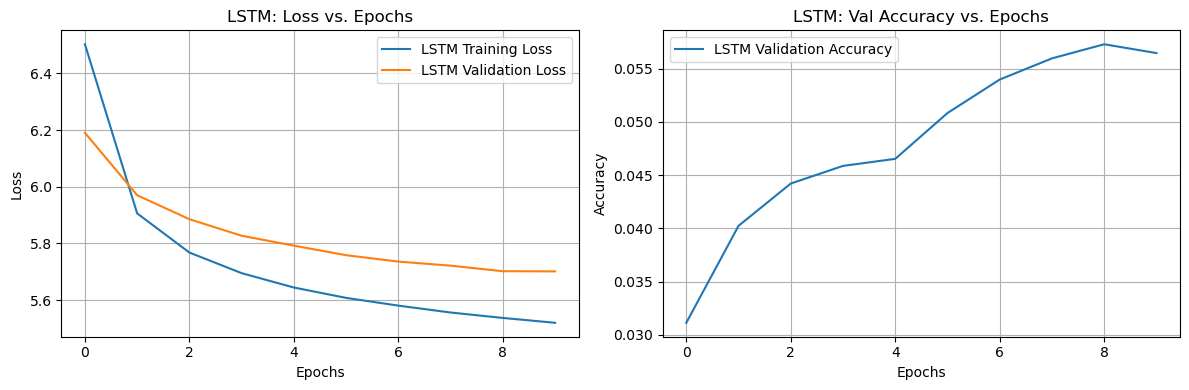


Evaluating LSTM model performance on the Test Set...

LSTM Model - Test Set Evaluation Results:
  HR@5: 0.1565, MRR@5: 0.0884, NDCG@5: 0.1052
  HR@10: 0.2381, MRR@10: 0.0991, NDCG@10: 0.1314
  HR@20: 0.3369, MRR@20: 0.1058, NDCG@20: 0.1562


In [13]:
print("\n--- Phase 6.2: LSTM Model Training ---")
lstm_model = None # Initialize
lstm_test_results = None # Initialize

class LSTMRecommender(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 num_layers=1, dropout_p=0.3, padding_idx=0):
        super(LSTMRecommender, self).__init__()
        self.embedding_dim, self.hidden_dim, self.vocab_size, self.num_layers = embedding_dim, hidden_dim, vocab_size, num_layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, num_layers=self.num_layers, 
                           batch_first=True, dropout=dropout_p if self.num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, input_sequences, hidden_cell_state=None):
        embedded_seq = self.dropout(self.embedding(input_sequences))
        _, (final_hidden_state, _) = self.lstm(embedded_seq, hidden_cell_state) # We only need h_n, not c_n for prediction head
        relevant_hidden_state = final_hidden_state[-1] if self.num_layers > 1 else final_hidden_state.squeeze(0)
        logits = self.fc(self.dropout(relevant_hidden_state))
        return logits

if 'num_unique_items_vocab' not in locals() or \
   'EMBEDDING_DIM' not in locals() or 'HIDDEN_DIM' not in locals() or \
   'NUM_GRU_LAYERS' not in locals() or 'DROPOUT_PROB' not in locals() or \
   'padding_token_idx' not in locals() or 'device' not in locals() or \
   'LEARNING_RATE' not in locals() or 'train_loader' not in locals() or 'val_loader' not in locals():
    print("Error: Necessary variables for LSTM model training not found.")
else:
    lstm_model = LSTMRecommender(
        vocab_size=num_unique_items_vocab, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
        output_dim=num_unique_items_vocab, num_layers=NUM_GRU_LAYERS, # Reusing GRU layer count for now
        dropout_p=DROPOUT_PROB, padding_idx=padding_token_idx
    ).to(device)
    print("\nLSTM Model Architecture:")
    print(lstm_model)

    criterion_lstm = nn.CrossEntropyLoss(ignore_index=padding_token_idx)
    optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
    LSTM_NUM_EPOCHS = 10 

    lstm_train_loss_hist, lstm_val_loss_hist, lstm_val_acc_hist = [], [], []
    print(f"\nStarting LSTM Training for {LSTM_NUM_EPOCHS} epochs...")
    for epoch in range(LSTM_NUM_EPOCHS):
        lstm_model.train()
        running_train_loss, num_train_samples = 0.0, 0
        if train_loader is None or len(train_loader) == 0: break
        for batch_sequences, batch_targets in train_loader:
            batch_sequences, batch_targets = batch_sequences.to(device), batch_targets.to(device)
            optimizer_lstm.zero_grad()
            outputs_logits = lstm_model(batch_sequences)
            loss = criterion_lstm(outputs_logits, batch_targets)
            loss.backward()
            optimizer_lstm.step()
            running_train_loss += loss.item() * batch_sequences.size(0)
            num_train_samples += batch_sequences.size(0)
        epoch_train_loss = running_train_loss / num_train_samples if num_train_samples > 0 else 0
        lstm_train_loss_hist.append(epoch_train_loss)
        print(f"Epoch [{epoch+1}/{LSTM_NUM_EPOCHS}] (LSTM) - Training Loss: {epoch_train_loss:.4f}")

        if val_loader is not None and len(val_loader) > 0:
            lstm_model.eval()
            running_val_loss, correct_val_preds, num_val_samples = 0.0, 0, 0
            with torch.no_grad():
                for batch_sequences, batch_targets in val_loader:
                    batch_sequences, batch_targets = batch_sequences.to(device), batch_targets.to(device)
                    outputs_logits = lstm_model(batch_sequences)
                    loss = criterion_lstm(outputs_logits, batch_targets)
                    running_val_loss += loss.item() * batch_sequences.size(0)
                    _, predicted_item_indices = torch.max(outputs_logits, 1)
                    correct_val_preds += (predicted_item_indices == batch_targets).sum().item()
                    num_val_samples += batch_targets.size(0)
            epoch_val_loss = running_val_loss / num_val_samples if num_val_samples > 0 else float('inf')
            val_accuracy = correct_val_preds / num_val_samples if num_val_samples > 0 else 0
            lstm_val_loss_hist.append(epoch_val_loss)
            lstm_val_acc_hist.append(val_accuracy)
            print(f"Epoch [{epoch+1}/{LSTM_NUM_EPOCHS}] (LSTM) - Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        else:
            lstm_val_loss_hist.append(float('nan'))
            lstm_val_acc_hist.append(float('nan'))
    print("\nLSTM Training Finished.")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1); plt.plot(lstm_train_loss_hist, label='LSTM Training Loss')
    if any(not np.isnan(x) for x in lstm_val_loss_hist): plt.plot(lstm_val_loss_hist, label='LSTM Validation Loss')
    plt.title('LSTM: Loss vs. Epochs'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    if any(not np.isnan(x) for x in lstm_val_acc_hist): plt.plot(lstm_val_acc_hist, label='LSTM Validation Accuracy')
    plt.title('LSTM: Val Accuracy vs. Epochs'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

    if test_loader is not None and len(test_loader) > 0:
        print("\nEvaluating LSTM model performance on the Test Set...")
        hr, mrr, ndcg = evaluate_recommender_metrics_v2(lstm_model, test_loader, device)
        lstm_test_results = {'HR': hr, 'MRR': mrr, 'NDCG': ndcg} 
        print("\nLSTM Model - Test Set Evaluation Results:")
        for k_val in hr.keys():
            print(f"  HR@{k_val}: {hr.get(k_val,0):.4f}, MRR@{k_val}: {mrr.get(k_val,0):.4f}, NDCG@{k_val}: {ndcg.get(k_val,0):.4f}")
    else:
        print("\nTest loader not available for LSTM model evaluation.")

### 6.3 Hyperparameter Tuning Strategies (Discussion)

We've used fixed hyperparameters so far. To truly optimize our models (GRU, LSTM, or future Transformer models), systematic hyperparameter tuning is essential. Here are some common strategies:

1.  **Manual Tuning:** Based on intuition and observing training curves, manually adjust parameters like learning rate, embedding dimension, hidden layer sizes, number of layers, dropout rate, `MAX_SEQUENCE_LENGTH`, and `BATCH_SIZE`. This is often a starting point.

2.  **Grid Search:** Define a grid of possible values for each hyperparameter you want to tune. The process then trains and evaluates the model for every possible combination of these values. 
    * **Pros:** Exhaustive.
    * **Cons:** Can be computationally very expensive, especially with many parameters or large value ranges.
    * Tools: `scikit-learn`'s `GridSearchCV` can be adapted for PyTorch models, often with wrappers like `Skorch` or by writing custom loops.

3.  **Random Search:** Instead of trying all combinations, randomly sample hyperparameter combinations from specified distributions or ranges for a fixed number of iterations.
    * **Pros:** Often more efficient than grid search and can find good combinations faster.
    * **Cons:** Not guaranteed to find the absolute optimum.
    * Tools: `scikit-learn`'s `RandomizedSearchCV`, or custom loops.

4.  **Bayesian Optimization & Advanced Methods:** These methods use information from past evaluations to make more informed choices about which hyperparameter combinations to try next. They aim to find good parameters with fewer evaluations.
    * **Pros:** Can be very efficient for expensive-to-train models.
    * **Tools:** Libraries like `Optuna`, `Hyperopt`, or `Ray Tune` are specifically designed for this and integrate well with PyTorch.
        * **Optuna Example (Conceptual):**
            ```python
            # import optuna
            # def objective(trial):
            #     lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
            #     hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
            #     # ... define model and train with these params ...
            #     # ... return validation_metric (e.g., -val_loss or val_ndcg) ...
            # study = optuna.create_study(direction='maximize') # or 'minimize'
            # study.optimize(objective, n_trials=50)
            # print("Best trial:", study.best_trial.params)
            ```

**Key Considerations for Tuning:**
* **Validation Set:** Always tune based on performance on a separate validation set, not the test set (the test set is for final, unbiased evaluation).
* **Metric:** Choose an appropriate metric to optimize (e.g., validation NDCG@10, validation MRR@10, or minimizing validation loss).
* **Computational Budget:** Be mindful of the time and resources available for tuning.

### 6.4 Qualitative Analysis: Understanding Model Predictions

Metrics like HR@K, MRR@K, and NDCG@K give us a quantitative understanding of performance. However, it's also incredibly insightful to perform **qualitative analysis** – looking at actual recommendations for specific users to understand *what* the model is learning and where it might be going wrong or surprisingly right.

**Steps for Qualitative Analysis:**

1.  **Select Users:** Choose a few users from your test set. It can be interesting to pick:
    * Users for whom the model performed well (high rank for the true next item).
    * Users for whom the model performed poorly.
    * Users with diverse interaction histories (long vs. short, varied vs. niche items).
2.  **Get Input Sequence:** For each selected user, retrieve the input sequence that was fed to the model from the test set (e.g., `X_test[user_idx]`). Remember to map the item indices back to actual movie titles or IDs if you have that mapping (`idx_to_item`).
3.  **Get Model's Top-K Predictions:** Pass the input sequence through your trained model to get the logits/scores. Then, identify the top K predicted item indices. Map these back to movie titles/IDs.
4.  **Identify True Next Item:** Get the actual next item the user interacted with from the test set (e.g., `y_test[user_idx]`) and map it back.
5.  **Analyze and Interpret:**
    * **History:** What kind of items did the user interact with in their history?
    * **Recommendations:** What kind of items did the model recommend?
    * **Alignment:** Do the recommendations seem logical given the history? Are they diverse? Are they too similar (filter bubble)?
    * **Correctness:** Was the true next item in the top K? If so, at what rank?
    * **Errors:** If the true item wasn't recommended or ranked low, can you hypothesize why? Did the user's interest suddenly shift? Did the model miss a subtle cue?

This kind of analysis doesn't directly improve metrics but provides invaluable insights for model debugging, understanding model behavior, and generating ideas for future improvements (e.g., feature engineering, model architecture changes).

In [15]:
def get_movie_titles(item_indices_list, idx_to_item_map, movie_titles_df=None, item_id_col='item_id', title_col='title'):
    """Helper function to convert item indices back to movie titles."""
    if isinstance(item_indices_list, torch.Tensor):
        item_indices_list = item_indices_list.cpu().numpy().tolist()
    elif isinstance(item_indices_list, np.ndarray):
        item_indices_list = item_indices_list.tolist()
        
    original_item_ids = [idx_to_item_map.get(idx, '<PAD_OR_UNKNOWN>') for idx in item_indices_list if idx != padding_token_idx]
    if movie_titles_df is not None:
        try:
            titles = []
            for orig_id in original_item_ids:
                if orig_id == '<PAD_OR_UNKNOWN>':
                    titles.append(orig_id)
                else:
                    title_entry = movie_titles_df[movie_titles_df[item_id_col] == int(orig_id)][title_col]
                    if not title_entry.empty:
                        titles.append(title_entry.iloc[0])
                    else:
                        titles.append(f"<ID:{orig_id}_NO_TITLE>")
            return titles
        except Exception as e:
            return original_item_ids 
    return original_item_ids 

MOVIES_FILE_PATH = os.path.join(DATA_DIR, 'movies.dat')
df_movies = None
if os.path.exists(MOVIES_FILE_PATH):
    try:
        df_movies = pd.read_csv(MOVIES_FILE_PATH, sep='::', header=None, 
                                names=['item_id', 'title', 'genres'], engine='python', encoding='latin-1')
        print("\nSuccessfully loaded movies.dat for titles.")
    except Exception as e:
        print(f"Error loading movies.dat: {e}. Titles will be item IDs.")
else:
    print("movies.dat not found. Titles will be item IDs for qualitative analysis.")

def perform_qualitative_analysis(user_idx_in_test_set, model_to_analyze, X_test_data, y_test_data, 
                                 idx_to_item_map, k=10, movie_titles_df=None, device_to_use='cpu'):
    if model_to_analyze is None or X_test_data is None or y_test_data is None:
        print("Model or test data not available for qualitative analysis.")
        return
    if not (0 <= user_idx_in_test_set < len(X_test_data)):
        print(f"Error: user_idx_in_test_set {user_idx_in_test_set} is out of bounds for X_test.")
        return
        
    model_to_analyze.eval() 
    model_to_analyze.to(device_to_use) 

    input_seq_indices = X_test_data[user_idx_in_test_set]
    true_target_idx = y_test_data[user_idx_in_test_set]
    input_seq_tensor = torch.tensor([input_seq_indices], dtype=torch.long).to(device_to_use)

    with torch.no_grad():
        logits = model_to_analyze(input_seq_tensor)
        _, top_k_preds_indices = torch.topk(logits.squeeze(0), k=k)
    
    history_titles = get_movie_titles(input_seq_indices, idx_to_item_map, movie_titles_df)
    predicted_titles = get_movie_titles(top_k_preds_indices.cpu().numpy(), idx_to_item_map, movie_titles_df)
    true_target_title_list = get_movie_titles([true_target_idx.item() if isinstance(true_target_idx, torch.Tensor) else true_target_idx], idx_to_item_map, movie_titles_df)
    true_target_title = true_target_title_list[0] if true_target_title_list else "<UNKNOWN_TARGET>"

    print(f"\n--- Qualitative Analysis for Test User Index: {user_idx_in_test_set} ---")
    print(f"Interaction History (last {MAX_SEQUENCE_LENGTH} items, non-padded shown):")
    display_history_indices = input_seq_indices if isinstance(input_seq_indices, list) else input_seq_indices.tolist()
    display_history_titles = get_movie_titles([idx for idx in display_history_indices if idx != padding_token_idx], idx_to_item_map, movie_titles_df)
    for title in display_history_titles:
         print(f"  - {title}")
    
    print(f"\nTrue Next Item:")
    true_target_display_idx = true_target_idx.item() if isinstance(true_target_idx, torch.Tensor) else true_target_idx
    print(f"  - {true_target_title} (Mapped Index: {true_target_display_idx})")

    print(f"\nModel's Top {k} Predictions:")
    for i, title in enumerate(predicted_titles):
        rank = i + 1
        predicted_idx = top_k_preds_indices[i].item()
        is_hit_str = "<<< HIT!" if predicted_idx == true_target_display_idx else ""
        print(f"  {rank}. {title} (Mapped Index: {predicted_idx}) {is_hit_str}")
    print("--------------------------------------------------")

if 'model' in locals() and model is not None and \
   'X_test' in locals() and 'y_test' in locals() and len(X_test) > 0 and \
   'idx_to_item' in locals() and 'device' in locals():
    
    sample_user_indices_to_analyze = [0, 15, 30] 
    if len(X_test) == 0:
        print("X_test is empty, cannot perform qualitative analysis.")
    else:
        if max(sample_user_indices_to_analyze) >= len(X_test):
            print(f"Warning: Sample user indices for qualitative analysis might be out of bounds for X_test (size {len(X_test)}). Adjusting.")
            sample_user_indices_to_analyze = [i for i in sample_user_indices_to_analyze if i < len(X_test)]

        if sample_user_indices_to_analyze:
            print("\nStarting Qualitative Analysis examples (using the first trained GRU model)...")
            for user_idx in sample_user_indices_to_analyze:
                perform_qualitative_analysis(user_idx, model, X_test, y_test, idx_to_item, k=10, movie_titles_df=df_movies, device_to_use=device)
        else:
            print("No valid user indices to analyze after bounds check for qualitative analysis.")
else:
    print("\nSkipping qualitative analysis: model, test data, idx_to_item map, or device is not defined/available.")


Successfully loaded movies.dat for titles.

Starting Qualitative Analysis examples (using the first trained GRU model)...

--- Qualitative Analysis for Test User Index: 0 ---
Interaction History (last 20 items, non-padded shown):
  - Secret Garden, The (1993)
  - Toy Story 2 (1999)
  - Airplane! (1980)
  - Pleasantville (1998)
  - Dumbo (1941)
  - Princess Bride, The (1987)
  - Snow White and the Seven Dwarfs (1937)
  - Miracle on 34th Street (1947)
  - Ponette (1996)
  - Schindler's List (1993)
  - Beauty and the Beast (1991)
  - Tarzan (1999)
  - Close Shave, A (1995)
  - Aladdin (1992)
  - Toy Story (1995)
  - Bug's Life, A (1998)
  - Antz (1998)
  - Hunchback of Notre Dame, The (1996)
  - Hercules (1997)
  - Mulan (1998)

True Next Item:
  - Pocahontas (1995) (Mapped Index: 47)

Model's Top 10 Predictions:
  1. Lion King, The (1994) (Mapped Index: 341) 
  2. Mulan (1998) (Mapped Index: 1579) 
  3. Prince of Egypt, The (1998) (Mapped Index: 2031) 
  4. Tarzan (1999) (Mapped Index: 

### 6.5 Implementing and Training a Transformer-based Model (SASRec-inspired)

Now, let's implement and train the `SASRecInspiredModel` we discussed conceptually. This involves using PyTorch's `nn.TransformerEncoder` and `nn.TransformerEncoderLayer`, along with careful handling of positional embeddings and attention masks (causal mask and padding mask).


--- Phase 6.5: SASRec-inspired Transformer Model Training ---

Instantiating SASRecInspiredModel for training...
SASRecInspiredModel(
  (item_embedding): Embedding(3417, 64, padding_idx=0)
  (positional_embedding): Embedding(20, 64)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=64, out_features=3417, b

c:\Users\amanp\anaconda3\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch [1/10] (SASRec) - Training Loss: 6.2499
Epoch [1/10] (SASRec) - Validation Loss: nan, Validation Accuracy: 0.0351
Epoch [2/10] (SASRec) - Training Loss: 5.7272
Epoch [2/10] (SASRec) - Validation Loss: nan, Validation Accuracy: 0.0482
Epoch [3/10] (SASRec) - Training Loss: 5.6188
Epoch [3/10] (SASRec) - Validation Loss: nan, Validation Accuracy: 0.0469
Epoch [4/10] (SASRec) - Training Loss: 5.5633
Epoch [4/10] (SASRec) - Validation Loss: nan, Validation Accuracy: 0.0498
Epoch [5/10] (SASRec) - Training Loss: 5.5274
Epoch [5/10] (SASRec) - Validation Loss: nan, Validation Accuracy: 0.0512
Epoch [6/10] (SASRec) - Training Loss: 5.5023
Epoch [6/10] (SASRec) - Validation Loss: nan, Validation Accuracy: 0.0520
Epoch [7/10] (SASRec) - Training Loss: 5.4836
Epoch [7/10] (SASRec) - Validation Loss: nan, Validation Accuracy: 0.0570
Epoch [8/10] (SASRec) - Training Loss: 5.4678
Epoch [8/10] (SASRec) - Validation Loss: nan, Validation Accuracy: 0.0525
Epoch [9/10] (SASRec) - Training Loss: 5

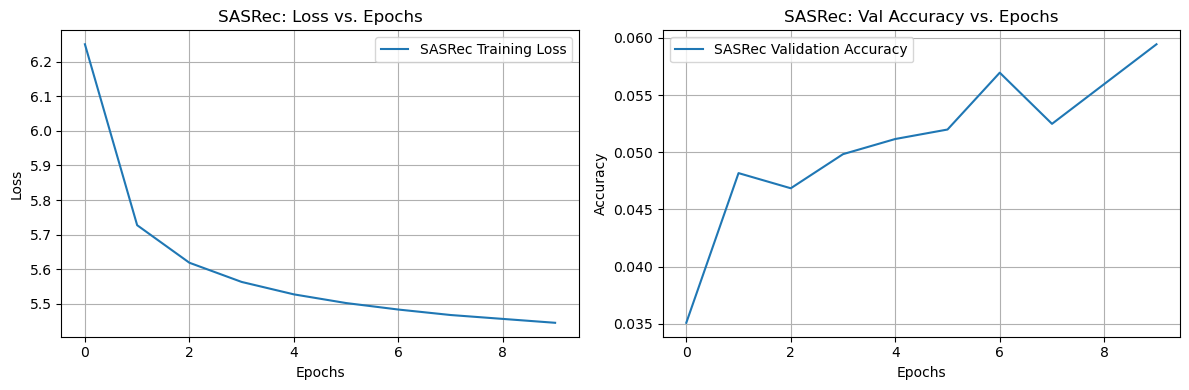


Evaluating SASRec model performance on the Test Set...

SASRec Model - Test Set Evaluation Results:
  HR@5: 0.1624, MRR@5: 0.0895, NDCG@5: 0.1075
  HR@10: 0.2411, MRR@10: 0.1001, NDCG@10: 0.1331
  HR@20: 0.3409, MRR@20: 0.1070, NDCG@20: 0.1582


In [16]:
print("\n--- Phase 6.5: SASRec-inspired Transformer Model Training ---")
import math
sasrec_model = None # Initialize
sasrec_test_results = None # Initialize

class SASRecInspiredModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_encoder_layers, 
                 dim_feedforward, dropout_p=0.1, padding_idx=0, max_seq_len=20):
        super(SASRecInspiredModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.item_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.positional_embedding = nn.Embedding(max_seq_len, embedding_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward,
            dropout=dropout_p, batch_first=True 
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.fc_out = nn.Linear(embedding_dim, vocab_size)
        self.dropout = nn.Dropout(dropout_p)
        self.max_seq_len = max_seq_len
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.item_embedding.weight.data.uniform_(-initrange, initrange)
        self.positional_embedding.weight.data.uniform_(-initrange, initrange)
        self.fc_out.bias.data.zero_()
        self.fc_out.weight.data.uniform_(-initrange, initrange)

    def _generate_causal_mask(self, sz, dev):
        mask = (torch.triu(torch.ones(sz, sz, device=dev)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, input_sequences):
        batch_size, seq_len = input_sequences.shape
        device_ = input_sequences.device
        positions_tensor = torch.arange(0, seq_len, device=device_).unsqueeze(0).repeat(batch_size, 1)
        
        item_embeds = self.item_embedding(input_sequences)
        pos_embeds = self.positional_embedding(positions_tensor)
        src = self.dropout(item_embeds + pos_embeds)

        src_key_padding_mask = (input_sequences == padding_token_idx)
        causal_mask = self._generate_causal_mask(seq_len, device_)
        
        transformer_output = self.transformer_encoder(
            src, mask=causal_mask, src_key_padding_mask=src_key_padding_mask
        )
        last_item_representation = transformer_output[:, -1, :]
        logits = self.fc_out(last_item_representation)
        return logits

if 'num_unique_items_vocab' not in locals() or \
   'padding_token_idx' not in locals() or \
   'MAX_SEQUENCE_LENGTH' not in locals() or \
   'device' not in locals() or \
   'train_loader' not in locals() or \
   'val_loader' not in locals() or \
   'test_loader' not in locals() or \
   'evaluate_recommender_metrics_v2' not in locals():
    print("Error: Necessary variables for SASRec model training/evaluation not found.")
else:
    TRANSFORMER_EMBEDDING_DIM = 64 
    TRANSFORMER_NUM_HEADS = 4
    TRANSFORMER_NUM_LAYERS = 2
    TRANSFORMER_DIM_FEEDFORWARD = TRANSFORMER_EMBEDDING_DIM * 4
    TRANSFORMER_DROPOUT = 0.2
    SASREC_LEARNING_RATE = 0.001
    SASREC_NUM_EPOCHS = 10

    print("\nInstantiating SASRecInspiredModel for training...")
    sasrec_model = SASRecInspiredModel(
        vocab_size=num_unique_items_vocab,
        embedding_dim=TRANSFORMER_EMBEDDING_DIM,
        num_heads=TRANSFORMER_NUM_HEADS,
        num_encoder_layers=TRANSFORMER_NUM_LAYERS,
        dim_feedforward=TRANSFORMER_DIM_FEEDFORWARD,
        dropout_p=TRANSFORMER_DROPOUT,
        padding_idx=padding_token_idx,
        max_seq_len=MAX_SEQUENCE_LENGTH
    ).to(device)
    print(sasrec_model)

    criterion_sasrec = nn.CrossEntropyLoss(ignore_index=padding_token_idx)
    optimizer_sasrec = torch.optim.Adam(sasrec_model.parameters(), lr=SASREC_LEARNING_RATE)

    sasrec_train_loss_hist, sasrec_val_loss_hist, sasrec_val_acc_hist = [], [], []
    print(f"\nStarting SASRec Model Training for {SASREC_NUM_EPOCHS} epochs...")
    for epoch in range(SASREC_NUM_EPOCHS):
        sasrec_model.train()
        running_train_loss, num_train_samples = 0.0, 0
        if train_loader is None or len(train_loader) == 0: break
        for batch_idx, (batch_sequences, batch_targets) in enumerate(train_loader):
            batch_sequences, batch_targets = batch_sequences.to(device), batch_targets.to(device)
            optimizer_sasrec.zero_grad()
            outputs_logits = sasrec_model(batch_sequences)
            loss = criterion_sasrec(outputs_logits, batch_targets)
            loss.backward()
            optimizer_sasrec.step()
            running_train_loss += loss.item() * batch_sequences.size(0)
            num_train_samples += batch_sequences.size(0)
        epoch_train_loss = running_train_loss / num_train_samples if num_train_samples > 0 else 0
        sasrec_train_loss_hist.append(epoch_train_loss)
        print(f"Epoch [{epoch+1}/{SASREC_NUM_EPOCHS}] (SASRec) - Training Loss: {epoch_train_loss:.4f}")

        if val_loader is not None and len(val_loader) > 0:
            sasrec_model.eval()
            running_val_loss, correct_val_preds, num_val_samples = 0.0, 0, 0
            with torch.no_grad():
                for batch_sequences, batch_targets in val_loader:
                    batch_sequences, batch_targets = batch_sequences.to(device), batch_targets.to(device)
                    outputs_logits = sasrec_model(batch_sequences)
                    loss = criterion_sasrec(outputs_logits, batch_targets)
                    running_val_loss += loss.item() * batch_sequences.size(0)
                    _, predicted_item_indices = torch.max(outputs_logits, 1)
                    correct_val_preds += (predicted_item_indices == batch_targets).sum().item()
                    num_val_samples += batch_targets.size(0)
            epoch_val_loss = running_val_loss / num_val_samples if num_val_samples > 0 else float('inf')
            val_accuracy = correct_val_preds / num_val_samples if num_val_samples > 0 else 0
            sasrec_val_loss_hist.append(epoch_val_loss)
            sasrec_val_acc_hist.append(val_accuracy)
            print(f"Epoch [{epoch+1}/{SASREC_NUM_EPOCHS}] (SASRec) - Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        else:
            sasrec_val_loss_hist.append(float('nan'))
            sasrec_val_acc_hist.append(float('nan'))
    print("\nSASRec Model Training Finished.")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1); plt.plot(sasrec_train_loss_hist, label='SASRec Training Loss')
    if any(not np.isnan(x) for x in sasrec_val_loss_hist): plt.plot(sasrec_val_loss_hist, label='SASRec Validation Loss')
    plt.title('SASRec: Loss vs. Epochs'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    if any(not np.isnan(x) for x in sasrec_val_acc_hist): plt.plot(sasrec_val_acc_hist, label='SASRec Validation Accuracy')
    plt.title('SASRec: Val Accuracy vs. Epochs'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

    if test_loader is not None and len(test_loader) > 0:
        print("\nEvaluating SASRec model performance on the Test Set...")
        hr, mrr, ndcg = evaluate_recommender_metrics_v2(sasrec_model, test_loader, device)
        sasrec_test_results = {'HR': hr, 'MRR': mrr, 'NDCG': ndcg}
        print("\nSASRec Model - Test Set Evaluation Results:")
        for k_val in hr.keys():
            print(f"  HR@{k_val}: {hr.get(k_val,0):.4f}, MRR@{k_val}: {mrr.get(k_val,0):.4f}, NDCG@{k_val}: {ndcg.get(k_val,0):.4f}")
    else:
        print("\nTest loader not available for SASRec model evaluation.")

### 6.6 Comparing Model Performance

After training and evaluating our GRU, LSTM, and SASRec-inspired models, let's put their test set performance side-by-side. This will help us understand which architecture performed best on this dataset with the current hyperparameter settings.

I'll create a summary table or print out the key metrics (HR@10, MRR@10, NDCG@10) for each model.

*(Make sure the evaluation cells for the GRU model (`test_hr_results`, `test_mrr_results`, `test_ndcg_results`), the Extended GRU (`model_ext_gru_test_results`), the LSTM model (`lstm_test_results`), and the SASRec model (`sasrec_test_results`) have been run and their results are stored.)*


--- Phase 6.6: Comparing Model Performance ---

--- Model Performance Comparison (Test Set @K=10) ---
                    HR@10    MRR@10   NDCG@10
GRU (Initial)    0.230795  0.096612  0.127898
GRU (Extended)   0.246026  0.105916  0.138566
LSTM             0.238079  0.099087  0.131367
SASRec-Inspired  0.241060  0.100111  0.133067


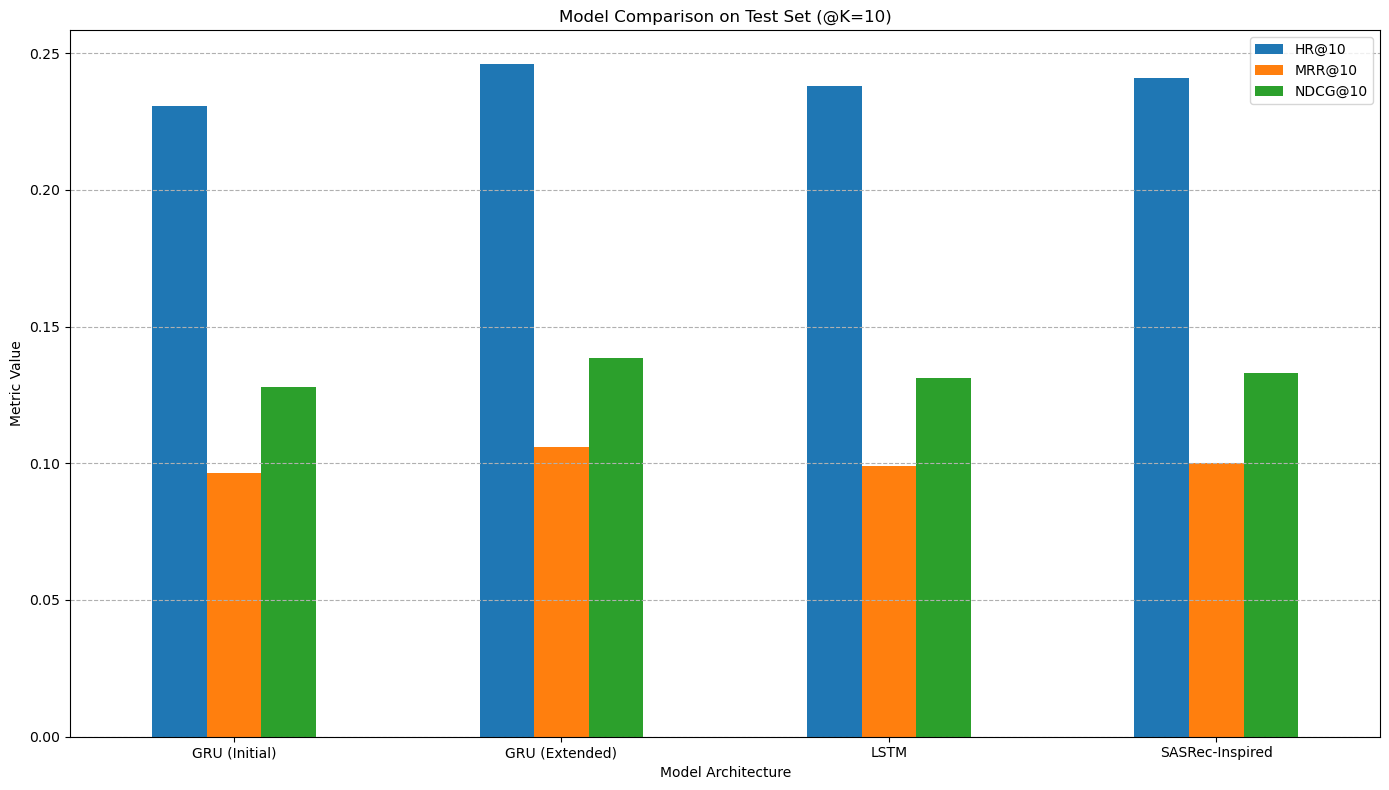


Discussion of Results:
- Review the table/chart above. Which model performed best on which metric?
- RNNs (GRU/LSTM) are good baselines. Transformers (SASRec) often perform better due to self-attention but might require more data or careful tuning.
- Differences could be due to: inherent model architecture strengths, hyperparameter choices (which were not extensively tuned here for all models), or training duration.
- For a real project, extensive hyperparameter optimization (e.g., using Optuna) would be performed for each model architecture to ensure a fair and robust comparison.


In [17]:
print("\n--- Phase 6.6: Comparing Model Performance ---")

results_summary = {}
k_compare = 10 # Key K value for comparison table

# GRU (Initial 10 epochs)
if 'test_hr_results' in locals() and isinstance(test_hr_results, dict): # Check if results from Phase 5 exist
    results_summary['GRU (Initial)'] = {
        f'HR@{k_compare}': test_hr_results.get(k_compare, 'N/A'),
        f'MRR@{k_compare}': test_mrr_results.get(k_compare, 'N/A'),
        f'NDCG@{k_compare}': test_ndcg_results.get(k_compare, 'N/A')
    }
else:
    print("Warning: Initial GRU model (Phase 5) results not found for comparison.")

# Extended GRU (with Early Stopping)
if 'model_ext_gru_test_results' in locals() and model_ext_gru_test_results is not None:
    results_summary['GRU (Extended)'] = {
        f'HR@{k_compare}': model_ext_gru_test_results['HR'].get(k_compare, 'N/A'),
        f'MRR@{k_compare}': model_ext_gru_test_results['MRR'].get(k_compare, 'N/A'),
        f'NDCG@{k_compare}': model_ext_gru_test_results['NDCG'].get(k_compare, 'N/A')
    }
else:
    print("Warning: Extended GRU model results not found for comparison.")

# LSTM Model
if 'lstm_test_results' in locals() and lstm_test_results is not None:
    results_summary['LSTM'] = {
        f'HR@{k_compare}': lstm_test_results['HR'].get(k_compare, 'N/A'),
        f'MRR@{k_compare}': lstm_test_results['MRR'].get(k_compare, 'N/A'),
        f'NDCG@{k_compare}': lstm_test_results['NDCG'].get(k_compare, 'N/A')
    }
else:
    print("Warning: LSTM model results not found for comparison.")

# SASRec-Inspired Model
if 'sasrec_test_results' in locals() and sasrec_test_results is not None:
    results_summary['SASRec-Inspired'] = {
        f'HR@{k_compare}': sasrec_test_results['HR'].get(k_compare, 'N/A'),
        f'MRR@{k_compare}': sasrec_test_results['MRR'].get(k_compare, 'N/A'),
        f'NDCG@{k_compare}': sasrec_test_results['NDCG'].get(k_compare, 'N/A')
    }
else:
    print("Warning: SASRec-inspired model results not found for comparison.")

print(f"\n--- Model Performance Comparison (Test Set @K={k_compare}) ---")
if not results_summary:
    print("No model results available to compare.")
else:
    comparison_df = pd.DataFrame.from_dict(results_summary, orient='index')
    print(comparison_df)

    if not comparison_df.empty:
        # Ensure data is numeric for plotting, replacing 'N/A' with 0 or NaN
        plot_df = comparison_df.apply(pd.to_numeric, errors='coerce').fillna(0)
        if not plot_df.empty:
            ax = plot_df.plot(kind='bar', figsize=(14, 8), rot=0)
            plt.title(f'Model Comparison on Test Set (@K={k_compare})')
            plt.ylabel('Metric Value')
            plt.xlabel('Model Architecture')
            plt.tight_layout()
            plt.grid(axis='y', linestyle='--')
            plt.show()
        else:
            print("Plotting DataFrame is empty after attempting to convert to numeric.")
    else:
        print("Comparison DataFrame is empty, cannot plot.")

print("\nDiscussion of Results:")
print("- Review the table/chart above. Which model performed best on which metric?")
print("- RNNs (GRU/LSTM) are good baselines. Transformers (SASRec) often perform better due to self-attention but might require more data or careful tuning.")
print("- Differences could be due to: inherent model architecture strengths, hyperparameter choices (which were not extensively tuned here for all models), or training duration.")
print("- For a real project, extensive hyperparameter optimization (e.g., using Optuna) would be performed for each model architecture to ensure a fair and robust comparison.")

### 6.7 Conceptual Dive into Negative Sampling

When our item vocabulary (`num_unique_items_vocab`) becomes very large (e.g., millions of items), calculating the softmax over all items in the output layer (`nn.Linear(hidden_dim, vocab_size)`) and then the `CrossEntropyLoss` becomes computationally very expensive during training.

**Negative Sampling** is a technique to address this. Instead of predicting a probability distribution over *all* items, the model is trained to distinguish the true next item (the positive sample) from a small number of randomly selected items that are *not* the true next item (the negative samples).

**Common Approaches:**

1.  **Sampled Softmax:** During training, for each positive target item, you sample a small set of negative items. The softmax is then computed only over this combined set (positive + sampled negatives). PyTorch doesn't have a direct `SampledSoftmaxLoss` layer like TensorFlow, so implementing this efficiently requires custom logic, often involving careful indexing and sparse operations if possible.

2.  **Noise Contrastive Estimation (NCE):** Similar in spirit to sampled softmax, NCE frames the problem as a binary classification task for each sample (positive or negative) against a noise distribution.

3.  **BPR Loss (Bayesian Personalized Ranking):**
    * Often used in matrix factorization but adaptable for sequential models.
    * For a given user and their input sequence, the model should score the true next item (positive item $i$) higher than a randomly sampled negative item $j$ (an item the user did not interact with next).
    * The loss function aims to maximize $score(positive\_item) - score(negative\_item)$.
    * The model's output layer might just output an embedding for the sequence, and you'd compute dot products with item embeddings (for positive and negative items) to get scores.

**How it Changes the Model/Training:**

* **Output Layer:** The final linear layer might not directly map to `vocab_size`. Instead, it might output a context embedding. You'd then need separate item embeddings.
* **Loss Function:** You'd use a custom loss or a binary cross-entropy if framing as positive vs. negative classification.
* **Data Loading:** Your `DataLoader` would need to provide not just the input sequence and the positive target, but also a set of negative samples for each training instance.

Implementing negative sampling effectively is an advanced topic and would require significant modifications to our current pipeline. It's something to consider if you scale up to much larger item sets.

## Project Conclusion

This comprehensive notebook has taken us through the entire process of building a sequential recommendation system, from data understanding and preprocessing to model implementation (GRU, LSTM, and a SASRec-inspired Transformer), training, robust evaluation (HR, MRR, NDCG), and exploration of advanced concepts like early stopping and qualitative analysis. We've also covered how to share this work by exporting to HTML.

There are always more avenues for improvement and research in recommendation systems, but this project provides a very solid foundation. I hope this has been a valuable and detailed learning experience!
